### About
### LLM-zoomcamp-04_Evaluation_Monitoring_Homework

### Import necessary libraries and packages

In [ ]:
pip install sentence_transformers==2.7.0 -qq

In [ ]:
pip install rouge -qq

In [30]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from matplotlib import pyplot as plt
import io
import os
import json
import requests
from tqdm.notebook import tqdm
import subprocess
import time
import json
from sentence_transformers import SentenceTransformer
from IPython.display import clear_output
from IPython.display import display, Markdown

from rouge import Rouge
rouge_scorer = Rouge()

### Get GPT-4o_mini results from coure repo

In [2]:
df_gpt4o_mini_url = 'https://raw.githubusercontent.com/DataTalksClub/llm-zoomcamp/main/04-monitoring/data/results-gpt4o-mini.csv'
df_gpt4o_mini=pd.read_csv(df_gpt4o_mini_url)
df_gpt4o_mini.head()

,answer_llm,answer_orig,document,question,course
0,You can sign up for the course by visiting the...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
1,You can sign up using the link provided in the...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp
2,"Yes, there is an FAQ for the Machine Learning ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp
3,The context does not provide any specific info...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Does this course have a GitHub repository for ...,machine-learning-zoomcamp
4,To structure your questions and answers for th...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,How can I structure my questions and answers f...,machine-learning-zoomcamp


### Filter first 300 rows

In [3]:
df_gpt4o_mini = df_gpt4o_mini.iloc[:300]

## Q1. Getting the embeddings model
```
Now, get the embeddings model multi-qa-mpnet-base-dot-v1 from the Sentence Transformer library

Note: this is not the same model as in HW3

from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name)
Create the embeddings for the first LLM answer:

answer_llm = df.iloc[0].answer_llm
What's the first value of the resulting vector?

-0.42
-0.22
-0.02
0.21
```

### Initialize sentence transformer

In [4]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer('multi-qa-mpnet-base-dot-v1')

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/8.71k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### sample generated llm answer

In [5]:
answer_llm  = df_gpt4o_mini.iloc[0].answer_llm

In [6]:
answer_llm

'You can sign up for the course by visiting the course page at [http://mlzoomcamp.com/](http://mlzoomcamp.com/).'

### Apply embedding to the sample generated llm answer

In [7]:
 answer_llm_vector_sample=embedding_model.encode(answer_llm, show_progress_bar=False)

In [9]:
answer_llm_vector_sample[0]

-0.4224466

### Q1 Answer: -0.42

## Q2. Computing the dot product
```
Now for each answer pair, let's create embeddings and compute dot product between them

We will put the results (scores) into the evaluations list

What's the 75% percentile of the score?

21.67
31.67
41.67
51.67
```

### Function to calculate similarity between two vectors

In [11]:
def compute_similarity(record,model):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = model.encode(answer_llm, show_progress_bar=False)
    v_orig = model.encode(answer_orig, show_progress_bar=False)
    
    return v_llm.dot(v_orig)

### Convert each row to dictionary

In [12]:
results_gpt4o_mini = df_gpt4o_mini.to_dict(orient='records')

In [13]:
results_gpt4o_mini[0]

{'answer_llm': 'You can sign up for the course by visiting the course page at [http://mlzoomcamp.com/](http://mlzoomcamp.com/).',
 'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'document': '0227b872',
 'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp'}

### Calculate similarity score for all records

In [14]:
evaluations = []

for record in tqdm(results_gpt4o_mini):
    sim = compute_similarity(record,embedding_model)
    evaluations.append(sim)

  0%|          | 0/300 [00:00<?, ?it/s]

### Similarity score numerical summary

In [46]:
df_gpt4o_mini['dot_product'] = evaluations
df_gpt4o_mini['dot_product'].describe()

count    300.000000
mean      27.495996
std        6.384742
min        4.547924
25%       24.307846
50%       28.336873
75%       31.674307
max       39.476009
Name: dot_product, dtype: float64

### Q2 Answer: 31.67

## Q3. Computing the cosine
```
From Q2, we can see that the results are not within the [0, 1] range. It's because the vectors coming from this model are not normalized.

So we need to normalize them.

To do it, we

Compute the norm of a vector
Divide each element by this norm
So, for vector v, it'll be v / ||v||

In numpy, this is how you do it:

norm = np.sqrt((v * v).sum())
v_norm = v / norm
Let's put it into a function and then compute dot product between normalized vectors. This will give us cosine similarity

What's the 75% cosine in the scores?

0.63
0.73
0.83
0.93
```

### Function to normalize the vector

In [15]:
def normalize(v):
    norm = np.sqrt((v * v).sum())
    v_norm = v / norm
    return v_norm

In [16]:
def compute_similarity_normalized(record,model):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = model.encode(answer_llm, show_progress_bar=False)
    v_orig = model.encode(answer_orig, show_progress_bar=False)
    
    v_llm = normalize(v_llm)
    v_orig = normalize(v_orig)
    
    return v_llm.dot(v_orig)

### Calculate normalized similarity score for all records

In [17]:
evaluations_normalized = []

for record in tqdm(results_gpt4o_mini):
    sim = compute_similarity_normalized(record,embedding_model)
    evaluations_normalized.append(sim)

  0%|          | 0/300 [00:00<?, ?it/s]

### Normalized similarity score numerical summary

In [47]:
df_gpt4o_mini['cosine'] = evaluations_normalized
df_gpt4o_mini['cosine'].describe()

count    300.000000
mean       0.728393
std        0.157755
min        0.125357
25%        0.651274
50%        0.763761
75%        0.836235
max        0.958796
Name: cosine, dtype: float64

### Q3 Answer: 0.83

## Q4. Rouge
```
Now we will explore an alternative metric - the ROUGE score.

This is a set of metrics that compares two answers based on the overlap of n-grams, word sequences, and word pairs.

It can give a more nuanced view of text similarity than just cosine similarity alone.

We don't need to implement it ourselves, there's a python package for it:

pip install rouge
(The latest version at the moment of writing is 1.0.1)

Let's compute the ROUGE score between the answers at the index 10 of our dataframe (doc_id=5170565b)

from rouge import Rouge
rouge_scorer = Rouge()

scores = rouge_scorer.get_scores(r['answer_llm'], r['answer_orig'])[0]
There are three scores: rouge-1, rouge-2 and rouge-l, and precision, recall and F1 score for each.

rouge-1 - the overlap of unigrams,
rouge-2 - bigrams,
rouge-l - the longest common subsequence
What's the F score for rouge-1?

0.35
0.45
0.55
0.65
```

### Sample record to calculate rouge score

In [19]:
df_gpt4o_mini[df_gpt4o_mini['document']=='5170565b']

,answer_llm,answer_orig,document,question,course,cosine_normalized
10,"Yes, all sessions are recorded, so if you miss...","Everything is recorded, so you won’t miss anyt...",5170565b,Are sessions recorded if I miss one?,machine-learning-zoomcamp,0.777956
11,"Yes, you can ask your questions in advance if ...","Everything is recorded, so you won’t miss anyt...",5170565b,Can I ask questions in advance if I can't atte...,machine-learning-zoomcamp,0.783566
12,"If you miss a session, don't worry! Everything...","Everything is recorded, so you won’t miss anyt...",5170565b,How will my questions be addressed if I miss a...,machine-learning-zoomcamp,0.904688
13,"Yes, there is a way to catch up on a missed se...","Everything is recorded, so you won’t miss anyt...",5170565b,Is there a way to catch up on a missed session?,machine-learning-zoomcamp,0.806303
14,"Yes, you can still interact with instructors a...","Everything is recorded, so you won’t miss anyt...",5170565b,Can I still interact with instructors after mi...,machine-learning-zoomcamp,0.727596


### Rouge score calculation

In [20]:
scores = rouge_scorer.get_scores(df_gpt4o_mini[df_gpt4o_mini['document']=='5170565b']['answer_llm'], df_gpt4o_mini[df_gpt4o_mini['document']=='5170565b']['answer_orig'])[0]

In [21]:
scores

{'rouge-1': {'r': 0.45454545454545453,
  'p': 0.45454545454545453,
  'f': 0.45454544954545456},
 'rouge-2': {'r': 0.21621621621621623,
  'p': 0.21621621621621623,
  'f': 0.21621621121621637},
 'rouge-l': {'r': 0.3939393939393939,
  'p': 0.3939393939393939,
  'f': 0.393939388939394}}

In [22]:
scores['rouge-1']['f']

0.45454544954545456

### Q4 Answer: 0.45

## Q5. Average rouge score
```
Let's compute the average between rouge-1, rouge-2 and rouge-l for the same record from Q4

0.35
0.45
0.55
0.65
```

In [23]:
(scores['rouge-1']['f']+scores['rouge-2']['f']+scores['rouge-l']['f'])/3

0.35490034990035496

### Q5 Answer: 0.35

## Q6. Average rouge score for all the data points
```
Now let's compute the score for all the records

rouge_1 = scores['rouge-1']['f']
rouge_2 = scores['rouge-2']['f']
rouge_l = scores['rouge-l']['f']
rouge_avg = (rouge_1 + rouge_2 + rouge_l) / 3
And create a dataframe from them

What's the average rouge_2 across all the records?

0.10
0.20
0.30
0.40
```

### Calculate rouge score for all records

In [24]:
rouge_1 = []
rouge_2 = []
rouge_l = []
rouge_avg = []
for i in tqdm(range(df_gpt4o_mini.shape[0])):
    scores = rouge_scorer.get_scores(df_gpt4o_mini.iloc[i]['answer_llm'], df_gpt4o_mini.iloc[i]['answer_orig'])[0]
    rouge_1.append(scores['rouge-1']['f'])
    rouge_2.append(scores['rouge-2']['f'])
    rouge_l.append(scores['rouge-l']['f'])
    rouge_avg.append((scores['rouge-1']['f'] + scores['rouge-2']['f'] + scores['rouge-l']['f']) / 3)
    

  0%|          | 0/300 [00:00<?, ?it/s]

In [49]:
np.mean(rouge_2)

0.20696501983423318

### Q6 Answer: 0.20

In [27]:
df_gpt4o_mini['rouge-1']=rouge_1
df_gpt4o_mini['rouge-2']=rouge_2
df_gpt4o_mini['rouge-l']=rouge_l
df_gpt4o_mini['rouge_avg']=rouge_avg

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


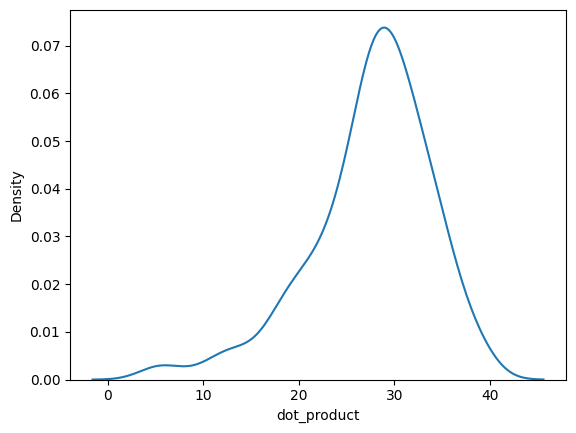

In [52]:
sns.kdeplot(df_gpt4o_mini['dot_product']);

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


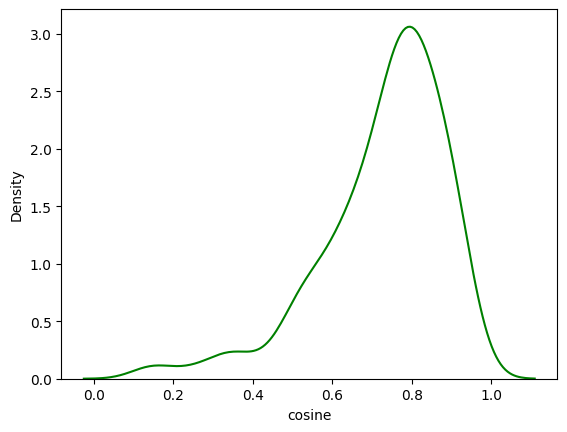

In [53]:
sns.kdeplot(df_gpt4o_mini['cosine'],color='green');

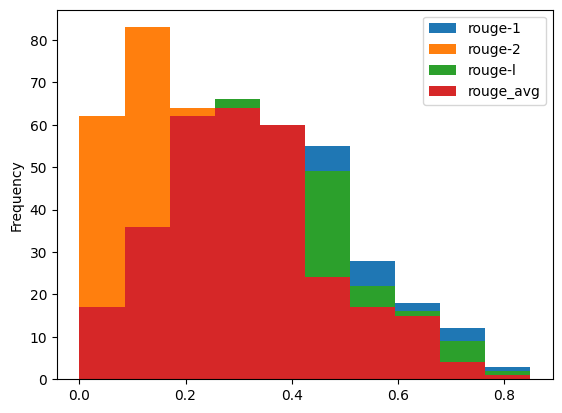

In [55]:
df_gpt4o_mini[['rouge-1','rouge-2','rouge-l','rouge_avg']].plot(kind='hist');

In [56]:
df_gpt4o_mini[['rouge-1','rouge-2','rouge-l','rouge_avg']].describe()

,rouge-1,rouge-2,rouge-l,rouge_avg
count,300.000000,300.000000,300.000000,300.000000
mean,0.378844,0.206965,0.353807,0.313205
std,0.165977,0.153550,0.162965,0.158133
min,0.000000,0.000000,0.000000,0.000000
25%,0.261625,0.097809,0.228032,0.197358
50%,0.378762,0.178671,0.337792,0.298640
75%,0.479281,0.286181,0.451613,0.404169
max,0.850000,0.739130,0.850000,0.813043
